#### Handwritten Digit Recognition using Convolutional Neural Networks

This notebook demonstrates how to build a Convolutional Neural Network (CNN) for recognizing handwritten digits using the popular MNIST dataset. The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0 to 9) and the corresponding labels. The dataset is split into 60,000 training images and 10,000 test images.

In [30]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [6]:
test_data.data.size()

torch.Size([10000, 28, 28])

In [7]:
train_data.targets.size()

torch.Size([60000])

In [8]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
from torch.utils.data import DataLoader

loaders = {

    "train": DataLoader(
                        train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1
    ),

    "test": DataLoader(
                        test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1
    )

}

In [10]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x192fe24bb20>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x192fe24b550>}

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # this is a max pooling layer
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # this is a dropout layer
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x)) # here we can add more layers
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x) # output layer

        return F.log_softmax(x, dim=1)
    
    

In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders["train"].dataset),
                100. * batch_idx / len(loaders["train"]), loss.item()))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(loaders["test"].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders["test"].dataset),
        100. * correct / len(loaders["test"].dataset)))
    
for epoch in range(1, 3):
    train(epoch)
    test()

# torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303913
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.285569
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.199565
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.086722
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.688686
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.448299
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.070254
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.118411
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.887336
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.940290
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.961388
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.773763
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.836639
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.715670
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.570816
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.833408
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.666863
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.529134
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.721269
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.692619
Train Epoch: 1 [200

In [19]:
device

device(type='cpu')

Prediction: 9


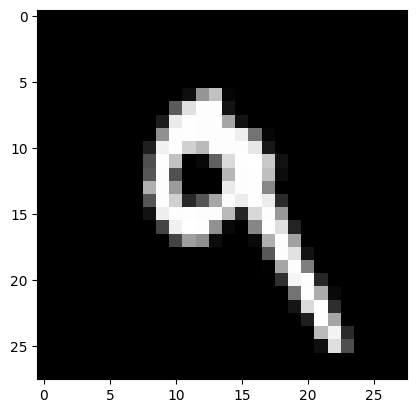

In [28]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[7]

data = data.unsqueeze(0).to(device)

output = model(data)

pred = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {pred}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

